**If there are any suggestions/changes you would like to see in the Kernel please let me know :). Appreciate every ounce of help!**<br>

<p>Please leave any comments about further improvements to the notebook! Any feedback or constructive criticism is greatly appreciated!. If you like it or it helps you , you can upvote and/or leave a comment :).|

In [1]:
import numpy as np
import os
from tqdm import tqdm
import wave
from scipy.io import wavfile
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Exploratory Data Analysis

In [2]:
train = pd.read_csv("../input/train_curated.csv")
test = pd.read_csv("../input/train_noisy.csv")

### Distribution of Categories

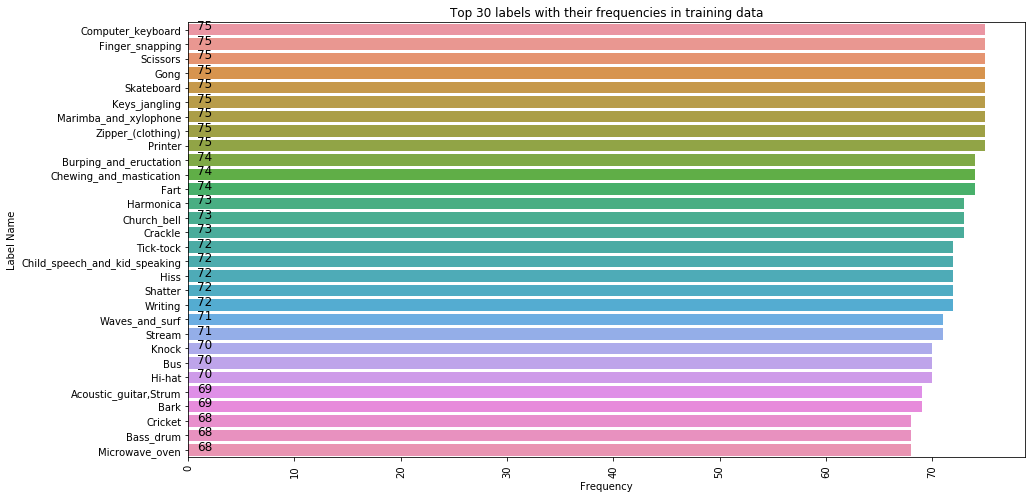

In [3]:
plt.figure(figsize=(15,8))
audio_type = train['labels'].value_counts().head(30)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('Label Name')
plt.title("Top 30 labels with their frequencies in training data")
plt.show()

### Audio Length
We shall now analyze the lengths of the audio files in our dataset of some categories

In [4]:
train_new = train.sort_values('labels').reset_index()
train_new['nframes'] = train_new['fname'].apply(lambda f: wave.open('../input/train_curated/' + f).getnframes())

train_fname = train_new.head(1000)

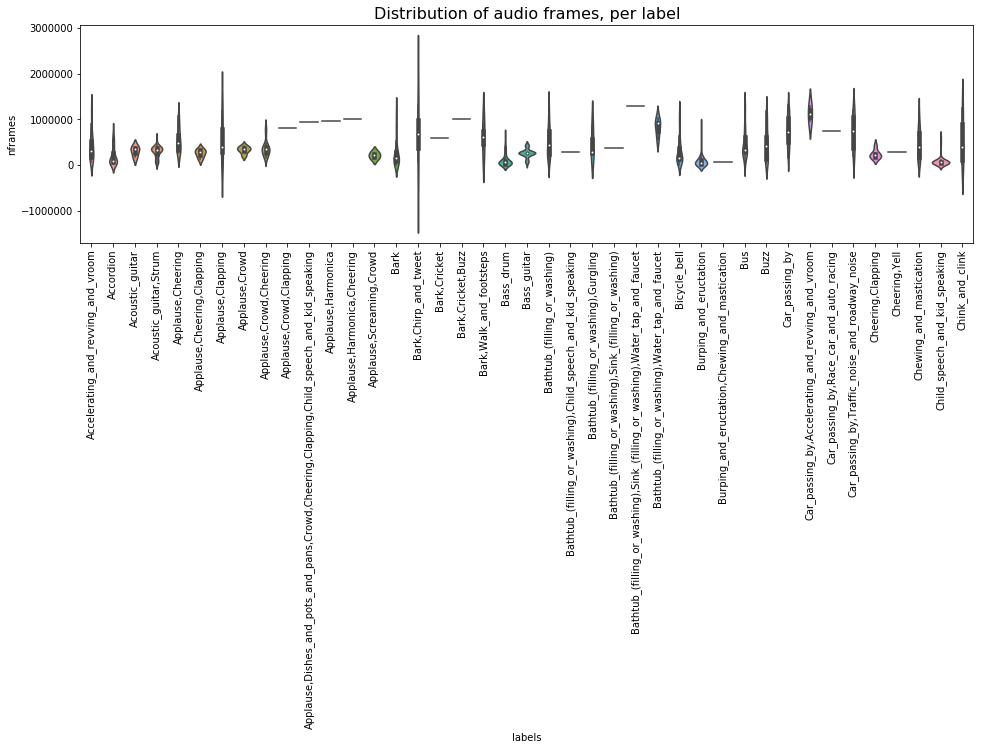

In [5]:
_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="labels", y="nframes", data=train_fname)
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

### Frame lenght distribution

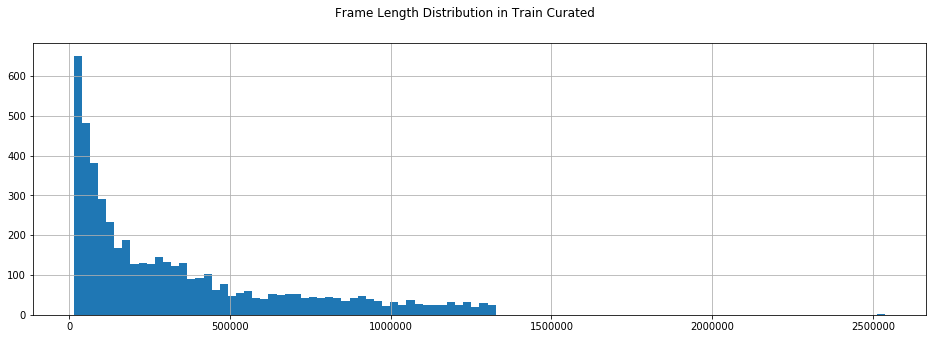

In [6]:
path = "../input/train_curated/"
fig, axes = plt.subplots(figsize=(16,5))
train_new.nframes.hist(bins=100)
plt.suptitle('Frame Length Distribution in Train Curated', ha='center', fontsize='large');

### Now look at some labels waveform 

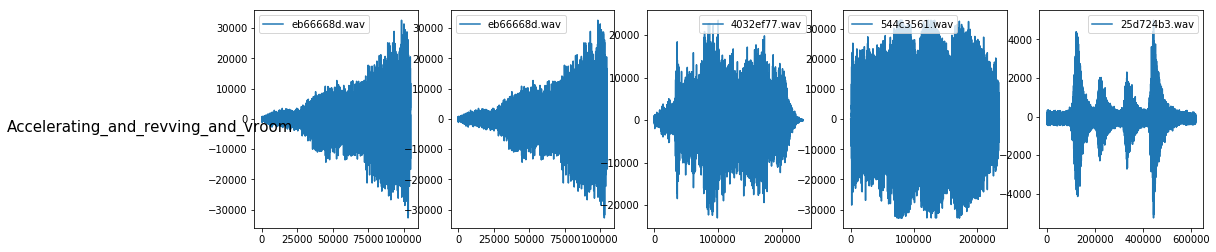

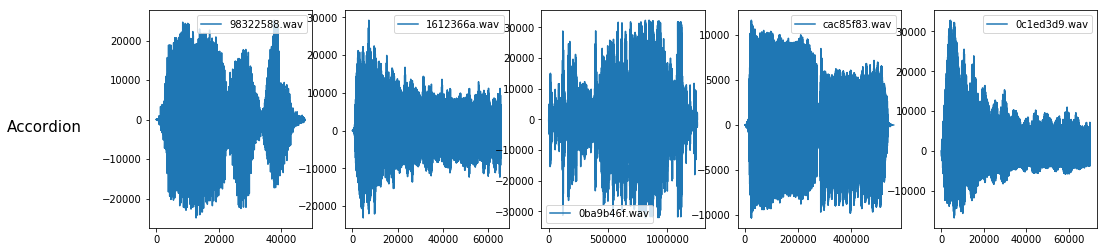

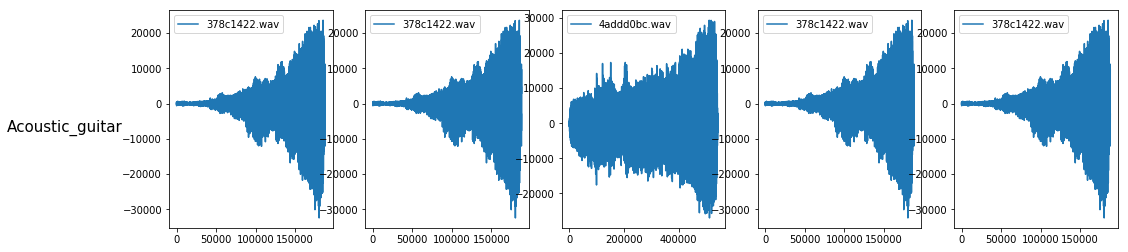

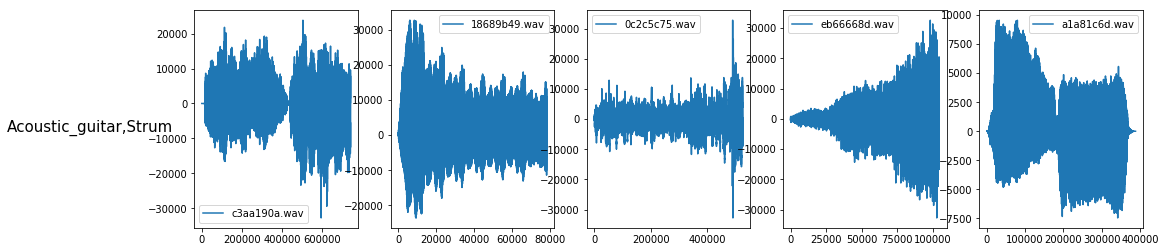

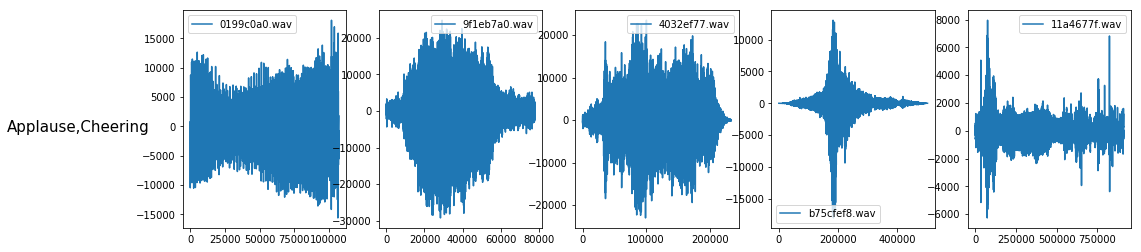

In [7]:
show_df = train.sort_values('labels')
labels = show_df['labels'].unique()

for label in labels[:5]:
    
    train_files_inds = show_df['labels'] == label

    rand_inds = np.random.randint(0,show_df['fname'][train_files_inds].count(),5)
    fnames = show_df['fname'].iloc[rand_inds]

    _, axs = plt.subplots(figsize=(17,4),nrows=1,ncols=5)

    for i,fname in enumerate(fnames):
        rate, data = wavfile.read(path + fname)
        axs[i].plot(data, '-', label=fname)
        axs[i].legend()
    plt.suptitle(label,x=0.04,y=0.5,horizontalalignment='center', fontsize=15)
    del rate
    del data
del axs

### Wordcloud for Labels

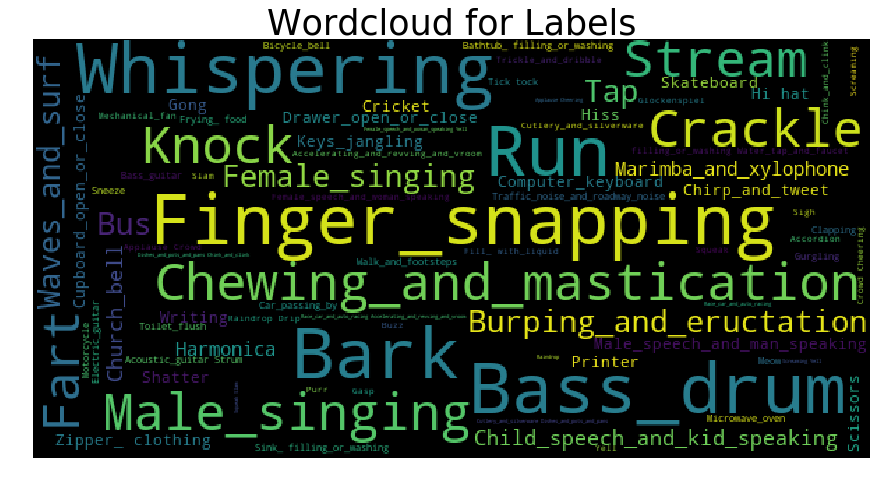

In [8]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(train.labels))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Wordcloud for Labels", fontsize=35)
plt.axis("off")
plt.show() 

## Remove uninformative Part

We will look on one example

In [9]:
##https://www.kaggle.com/ilyamich/remove-uninformative-parts-from-the-audio-files
import os

TRAIN_PATH = '../input/train_curated/'
train_ids = next(os.walk(TRAIN_PATH))[2]
train_ids[0]

'8a8110c2.wav'

In [10]:
import IPython.display as ipd
ipd.Audio(TRAIN_PATH + "8a8110c2.wav")

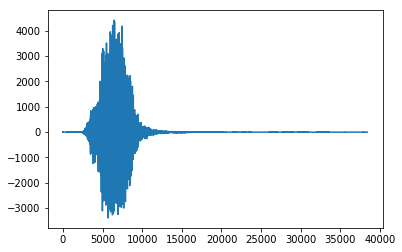

In [11]:
sample_rate, audio = wavfile.read(TRAIN_PATH + "8a8110c2.wav")
plt.plot(audio);

So the idea is to crop and segment the audio files and leave only the part that contain information.<br>
First wi will normalize the data to be between -1 and 1:

In [12]:
def normalize_audio(audio):
    audio = audio / max(np.abs(audio))
    return audio

It measures the power in each segment and based on that decides if this part is a noise.<br>
And returns the start and stop of each segment in the audio

In [13]:
def divide_audio(audio, resolution=100, window_duration=0.1, minimum_power=0.001, sample_rate=44100):    
    duration = len(audio) / sample_rate #in seconds
    itterations = int(duration * resolution)
    step = int(sample_rate / resolution)
    window_length = np.floor(sample_rate*window_duration)
    audio_power = np.square(normalize_audio(audio)) / window_length #Normalized power to window duration
    
    start = np.array([])
    stop = np.array([])
    is_started = False
    
    for n in range(itterations):
        power = np.sum(audio_power[n*step : int(n*step+window_length)])
        if not is_started and power > minimum_power:
            start = np.append(start, n*step+window_length/2)
            is_started = True
        elif is_started and (power <= minimum_power or n == itterations-1):
            stop = np.append(stop, n*step+window_length/2)
            is_started = False
    
    if start.size == 0:
        start = np.append(start, 0)
        stop = np.append(stop, len(audio))
        
    start = start.astype(int)
    stop = stop.astype(int)
    return start, stop

[2205]
[11466]


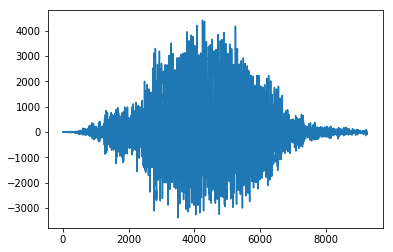

In [14]:
start, stop =  divide_audio(audio)
print(start)
print(stop)
plt.plot(audio[start[0]:stop[0]]);

After some manual tunning it seems that the it works<br>
Now lets briefly look on more examples:

100%|██████████| 40/40 [00:02<00:00, 16.76it/s]


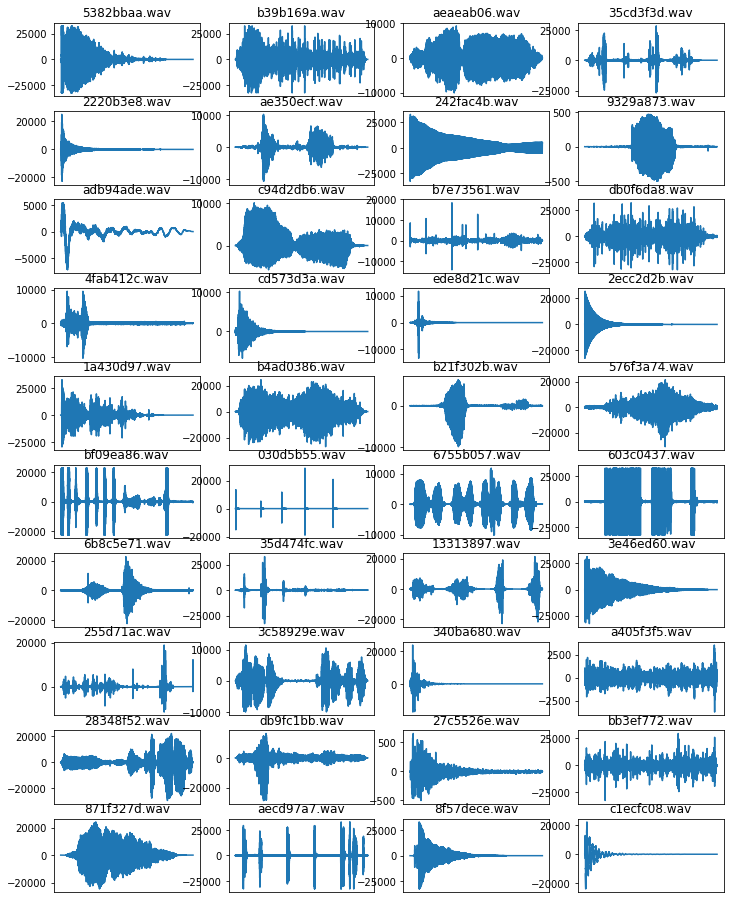

In [15]:
columns = ['File Name', 'Audio Duration', 'Segment Number']
audio_segments = pd.DataFrame(columns=columns)

fig, ax = plt.subplots(10, 4, figsize = (12, 16))
for i in tqdm(range(40), total=40):
    random_audio_idxs = np.random.randint(len(train_ids)+1, size=1)[0]
    _, tmp = wavfile.read(TRAIN_PATH + train_ids[random_audio_idxs])
    start, stop = divide_audio(tmp)
    
    audio_segments = audio_segments.append({'File Name': train_ids[random_audio_idxs],
                                            'Audio Duration': len(tmp)/sample_rate,
                                            'Segment Number': len(start)}, ignore_index=True)
    
    ax[i//4, i%4].plot(tmp)
    ax[i//4, i%4].set_title(train_ids[random_audio_idxs])
    ax[i//4, i%4].get_xaxis().set_ticks([])

In [16]:
audio_segments.sample(5)

,File Name,Audio Duration,Segment Number
5,ae350ecf.wav,2.314467,2
3,35cd3f3d.wav,8.260340,10
6,242fac4b.wav,6.250000,1
35,bb3ef772.wav,18.121179,4
7,9329a873.wav,1.625397,1


# More To Come. Stayed Tuned !!